# 공공데이터를 활용한 미세먼지 농도 예측 프로젝트
## 단계2. 모델링(머신러닝)

## 0.프로젝트 소개

### (1) 수행 목표
- 미세먼지 농도를 예측하는 머신러닝 모델을 만드세요.

#### 우리가 풀어야 하는 문제는 무엇인가요?
* 서울 지역의 미세먼지 데이터와 날씨 데이터를 활용하여,
미세먼지 예측에 관련 있는 데이터 항목으로 데이터를 구성, 전처리 하여
미세먼지 농도를 예측하는 머신러닝 모델 구현


### (2) 데이터 소개

#### 1) 기본 데이터

* 학습 데이터
    * air_2021.csv : 2021년 미세먼지 데이터
    * weather_2021.csv : 2021년 날씨 데이터
* 테스트 데이터
    * air_2022.csv : 2022년 미세먼지 데이터
    * weather_2022.csv : 2022년 날씨 데이터

#### 2) 데이터셋의 변수 소개(weather_2021)

* 증기압: 증기가 고체 또는 액체와 동적 평형 상태에 있을 때 증기의 압력 (증기가 되려는 힘)
* 이슬점 온도: 불포화 상태의 공기가 냉각될 때, 포화 상태에 도달하여 수증기의 응결이 시작되는 온도
* 일조: 일정한 물체나 땅의 겉면에 태양 광선이 비치는 시간 (1시간 중 비율)
* 일사(량): 태양으로부터 오는 태양 복사 에너지가 지표에 닿는 양 (면적당 에너지 량)
* 전운량: 하늘을 육안으로 관측하여 전부 구름일 때 10, 구름이 덮고 있는 하늘의 비율에 따라 0~10
* 중하층운량: 중층과 하층에 있는 구름의 분포량(중하층 구름이 날씨에 영향 주므로 따로 표기)
* 운형(운형약어): 구름의 종류. 약어 코드로 기재됨
* 최저운고: 가장 낮은 구름의 높이
* 현상번호(국내식): 비, 소낙비, 싸락눈, 눈보라 등의 기상현상을 나타낸 코드번호
* 지면온도: 지면 0cm 온도
* 지중온도: 땅 속 온도변수1

#### 2) 라이브러리 로딩

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.8 MB/s eta 0:00:00


In [3]:
# 필요한 라이브러리 설치 및 임포트
import pandas as pd
import numpy as np
import os

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as recall
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# [Step 3] 머신러닝 모델링 1

#### **<span style="color:blue">[3-1] 학습 및 테스트 데이터 로딩</span>**

In [4]:
os.chdir('/content/drive/MyDrive/AI+X_중급/개인과제_미세먼지')

In [5]:
# train_x.csv / train_y.csv / test_x.csv / test_y.csv 4개의 데이터 로딩
train_x = pd.read_csv('train_x.csv')
train_y = pd.read_csv('train_y.csv')
test_x = pd.read_csv('test_x.csv')
test_y = pd.read_csv('test_y.csv')

In [6]:
# 각 데이터프레임이 비어 있는지 확인
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)

# train_x 또는 train_y에 결측치가 포함되어 있는지 확인
print("train_x 결측치 개수:\n", train_x.isnull().sum())
print("train_y 결측치 개수:\n", train_y.isnull().sum())

train_x shape: (8432, 26)
train_y shape: (8432, 1)
test_x shape: (2049, 26)
test_y shape: (2049, 1)
train_x 결측치 개수:
 SO2              0
CO               0
O3               0
NO2              0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
풍향(16방위)         0
습도(%)            0
현지기압(hPa)        0
해면기압(hPa)        0
일조(hr)           0
일사(MJ/m2)        0
적설(cm)           0
전운량(10분위)        0
중하층운량(10분위)      0
시정(10m)          0
지면온도(°C)         0
10cm 지중온도(°C)    0
20cm 지중온도(°C)    0
30cm 지중온도(°C)    0
PM10             0
month            0
day              0
hour             0
PM10_lag1        0
dtype: int64
train_y 결측치 개수:
 PM10_1    0
dtype: int64


---

#### **<span style="color:blue">[3-2] 모델링 </span>**

* 머신 모델을 선정하여 아래에 적절한 코드를 작성해주세요.

In [7]:
# Min-Max 스케일러 객체 생성
scaler = MinMaxScaler()
# scaler = StandardScaler()

# train_x와 test_x 데이터 스케일링
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

# [Step 4] 머신러닝 모델링2

- LinearRegression

In [ ]:
# 회귀 모델 정의
lr_model = LinearRegression()

# 모델 학습
lr_model.fit(train_x, train_y)

LinearRegression()

In [ ]:
# 예측 수행
train_predictions = lr_model.predict(train_x)
test_predictions = lr_model.predict(test_x)

test_mse = mse(test_y, test_predictions)
test_r2 = r2_score(test_y, test_predictions)

In [ ]:
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")

Test MSE: 37.8091
Test R^2 Score: 0.9321


In [ ]:
# 학습한 모델을 파일로 저장해보세요.
joblib.dump(lr_model, 'lr_model.pkl')

['lr_model.pkl']

- RandomForest Regressor

In [ ]:
# 랜덤 포레스트 모델을 사용하여 학습
rf_model = RFR(n_estimators=100, random_state = 42)
rf_model.fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [ ]:
# Test 데이터로 성능을 평가해보세요.
predictions_rf = rf_model.predict(test_x)
mse_value_rf = mse(test_y, predictions_rf)
r2_value_rf = r2_score(test_y, predictions_rf)

print(f'Random Forest Model MSE: {mse_value_rf}')
print(f'Random Forest Model R2 Score: {r2_value_rf}')

# 학습한 모델을 파일로 저장해보세요.
joblib.dump(rf_model, 'rf_model.pkl')

Random Forest Model MSE: 40.563736359199616
Random Forest Model R2 Score: 0.9271910926604465


['rf_model.pkl']

- Ridge

In [ ]:
# 릿지 회귀 모델을 사용하여 학습
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(train_x, train_y)

Ridge()

In [ ]:
# Test 데이터로 성능을 평가해보세요.
predictions_ridge = ridge_model.predict(test_x)
mse_value_ridge = mse(test_y, predictions_ridge)
r2_value_ridge = r2_score(test_y, predictions_ridge)

print(f'Ridge Model MSE: {mse_value_ridge}')
print(f'Ridge Model R2 Score: {r2_value_ridge}')

Ridge Model MSE: 38.29543811171623
Ridge Model R2 Score: 0.9312625202887358


In [ ]:
# 학습한 모델을 파일로 저장해보세요.
joblib.dump(ridge_model, 'ridge_model.pkl')

['ridge_model.pkl']

- GradientBoostingRegressor

In [ ]:
# GBM 모델을 사용하여 학습
gbm_model = GBR(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm_model.fit(train_x, train_y)

# Test 데이터로 성능을 평가해보세요.
predictions_gbm = gbm_model.predict(test_x)
mse_value_gbm = mse(test_y, predictions_gbm)
r2_value_gbm = r2_score(test_y, predictions_gbm)

print(f'GBM Model MSE: {mse_value_gbm}')
print(f'GBM Model R2 Score: {r2_value_gbm}')

# 학습한 모델을 파일로 저장해보세요.
joblib.dump(gbm_model, 'gbm_model.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GBM Model MSE: 46.74120224140946
GBM Model R2 Score: 0.9161029981854152


['gbm_model.pkl']

- CatBoostRegressor

In [ ]:
# 4. CatBoost Regressor
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=False)
cat_model.fit(train_x, train_y,)  # 범주형 컬럼 리스트 추가

# 예측 및 성능 평가
cat_preds = cat_model.predict(test_x)
cat_mse = mse(test_y, cat_preds)
print(f'CatBoost MSE: {cat_mse}')
print(f'CatBoost R2 Score: {r2_score(test_y, cat_preds)}')

CatBoost MSE: 39.08232309741797
CatBoost R2 Score: 0.9298501199244422


- Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

# 라쏘 회귀 모델 설정 및 학습
lasso_model = Lasso(alpha=0.01, random_state=42)
lasso_model.fit(train_x, train_y)

# Test 데이터로 성능 평가
predictions_lasso = lasso_model.predict(test_x)
mse_value_lasso = mse(test_y, predictions_lasso)
r2_value_lasso = r2_score(test_y, predictions_lasso)

print(f'Lasso Model MSE: {mse_value_lasso}')
print(f'Lasso Model R2 Score: {r2_value_lasso}')

# 학습한 모델 파일로 저장
joblib.dump(lasso_model, 'lasso_model.pkl')

Lasso Model MSE: 37.6421105831474
Lasso Model R2 Score: 0.9324351948931836


['lasso_model.pkl']

- SVR

In [ ]:
from sklearn.svm import SVR

# 서포트 벡터 회귀 모델 설정 및 학습
svr_model = SVR(kernel='rbf', C=1000000, epsilon=0.5)
svr_model.fit(train_x, train_y.values.ravel())  # y값이 1차원이므로 ravel() 사용

# Test 데이터로 성능 평가
predictions_svr = svr_model.predict(test_x)
mse_value_svr = mse(test_y, predictions_svr)
r2_value_svr = r2_score(test_y, predictions_svr)

print(f'SVR Model MSE: {mse_value_svr}')
print(f'SVR Model R2 Score: {r2_value_svr}')

# 학습한 모델 파일로 저장
joblib.dump(svr_model, 'svr_model.pkl')

SVR Model MSE: 36.315279019825866
SVR Model R2 Score: 0.9348167594387574


['svr_model.pkl']

In [ ]:
# 확인할 수 있는 인사이트
# 1. MinMax나 Standard scaler의 적용 유무는 성능의 차이가 그렇게 크지 않지만, MinMax가 근소한 차이로 제일 좋음
# 2. 다른 컬럼을 추가해서 돌려봤을 때 보단, 지금 데이터 셋이 더 좋음(ex.PM25인 초미세먼지 컬럼을 추가하면 성능 저하)
# 3. 실험해 본 7개의 모델들의 성능이 그렇게 엄청난 차이가 있지 않음. KNN은 성능이 확연히 떨어져서 제거. 다 R2스코어를 0.9를 넘음음

# [Step 5] 머신러닝 모델에 대해 성능 최적화 진행

- HyperOpt로 최적의 하이퍼 파라미터 찾기 : Ridge

In [ ]:
# 목적 함수 정의
def objective(params):
    model = Ridge(**params)
    # 교차 검증을 통해 모델 성능 평가
    score = -cross_val_score(model, train_x, train_y, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': score, 'status': STATUS_OK}

# 하이퍼파라미터 공간 정의
space = {
    'alpha': hp.loguniform('alpha', np.log(0.001), np.log(10))
}

# 최적화 실행
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters:", best)

In [ ]:
# 최적의 하이퍼파라미터로 모델 학습
best_alpha = best['alpha']
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(train_x, train_y)

# 모델 예측
predictions_ridge = ridge_model.predict(test_x)

# 모델 성능 평가
mse_value_ridge = mse(test_y, predictions_ridge)
r2_value_ridge = r2_score(test_y, predictions_ridge)

print(f'Ridge Model with Best Alpha MSE: {mse_value_ridge}')
print(f'Ridge Model with Best Alpha R2 Score: {r2_value_ridge}')

- HyperOpt로 최적의 하이퍼 파라미터 찾기 : RandomForestRegressor

In [ ]:
# 목적 함수 정의
def objective(params):
    model = RFR(**params, random_state=42, n_jobs=-1)
    # 교차 검증을 통해 모델 성능 평가
    score = -cross_val_score(model, train_x, train_y, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': score, 'status': STATUS_OK}

# 하이퍼파라미터 공간 정의
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'max_depth': hp.choice('max_depth', range(5, 30)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 5))
}

# 최적화 실행
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters:", best)

# 최적의 하이퍼파라미터로 모델 학습
best_params = {
    'n_estimators': best['n_estimators'],
    'max_depth': best['max_depth'],
    'min_samples_split': best['min_samples_split'],
    'min_samples_leaf': best['min_samples_leaf']
}

rf_model = RFR(**best_params, random_state=42, n_jobs=-1)
rf_model.fit(train_x, train_y)

# Test 데이터로 성능을 평가해보세요.
predictions_rf = rf_model.predict(test_x)
mse_value_rf = mse(test_y, predictions_rf)
r2_value_rf = r2_score(test_y, predictions_rf)

print(f'Random Forest Model with Best Hyperparameters MSE: {mse_value_rf}')
print(f'Random Forest Model with Best Hyperparameters R2 Score: {r2_value_rf}')

# 학습한 모델을 파일로 저장해보세요.
joblib.dump(rf_model, 'rf_model.pkl')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score

# RandomForestRegressor 모델 초기화 (모든 CPU 코어 사용)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# 모델 학습
rf_model.fit(train_x, train_y)

# 모델 예측
predictions_rf = rf_model.predict(test_x)

# 모델 성능 평가
mse_value_rf = mse(test_y, predictions_rf)
r2_value_rf = r2_score(test_y, predictions_rf)

print(f'RandomForestRegressor Model MSE: {mse_value_rf}')
print(f'RandomForestRegressor Model R2 Score: {r2_value_rf}')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor Model MSE: 40.563736359199616
RandomForestRegressor Model R2 Score: 0.9271910926604465


- HyperOpt로 최적의 하이퍼 파라미터 찾기 : xgboost

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# XGBoost 목적 함수 정의
def xgb_objective(params):
    params['max_depth'] = int(params['max_depth'])  # 정수로 변환
    params['n_estimators'] = int(params['n_estimators'])  # 정수로 변환
    params['tree_method'] = 'hist'  # 최신 GPU 설정
    params['device'] = 'cuda'       # GPU 사용
    model = xgb.XGBRegressor(**params)
    score = -cross_val_score(model, train_x, train_y, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': score, 'status': STATUS_OK}

# XGBoost 하이퍼파라미터 공간 정의
xgb_space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# XGBoost 최적화 실행
xgb_trials = Trials()
best_xgb = fmin(
    fn=xgb_objective,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=xgb_trials,
    show_progressbar=True  # 진행 상황 표시
)

100%|██████████| 100/100 [08:05<00:00,  4.86s/trial, best loss: 375.7630151918271]


In [ ]:
xgb_model = xgb.XGBRegressor(
    max_depth=int(best_xgb['max_depth']),
    learning_rate=best_xgb['learning_rate'],
    n_estimators=int(best_xgb['n_estimators']),
    subsample=best_xgb['subsample'],
    colsample_bytree=best_xgb['colsample_bytree'],
    tree_method='hist',
    device='cuda'
)
xgb_model.fit(train_x, train_y)
predictions_xgb = xgb_model.predict(test_x)

# XGBoost 모델 성능 평가
mse_value_xgb = mse(test_y, predictions_xgb)
r2_value_xgb = r2_score(test_y, predictions_xgb)

print(f'XGBoost Model MSE: {mse_value_xgb}')
print(f'XGBoost Model R2 Score: {r2_value_xgb}')

XGBoost Model MSE: 44.3303671591786
XGBoost Model R2 Score: 0.9204303026199341


- Ensemble 진행

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.6 MB/s eta 0:00:00
  

In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.regression import *

from sklearn.ensemble import StackingRegressor
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
class FineDustPredictor:
    def __init__(self, train_x_path, train_y_path, test_x_path, test_y_path):
        self.train_x = pd.read_csv(train_x_path)
        self.train_y = pd.read_csv(train_y_path)
        self.test_x = pd.read_csv(test_x_path)
        self.test_y = pd.read_csv(test_y_path)
        # self.scaler = StandardScaler()
        self.scaler = MinMaxScaler()
        self.tuned_models = []
        self.results = {}
        self.pre_tuning_results = {}

    def normalize_data(self):
        """Normalize the training and testing datasets."""
        self.train_x = pd.DataFrame(self.scaler.fit_transform(self.train_x), columns=self.train_x.columns)
        self.test_x = pd.DataFrame(self.scaler.transform(self.test_x), columns=self.test_x.columns)

    def setup_autoML(self):
        """Set up PyCaret for AutoML and compare models."""
        self.data = pd.concat([self.train_x, self.train_y], axis=1)
        setup(data=self.data, target=self.train_y.columns[0], session_id=42, use_gpu=True)

    def compare_models(self):
        """Compare models based on R2 score and return top 5 models."""
        self.best_models = compare_models(sort='R2', n_select=5)
        return self.best_models

    def evaluate_models(self, models, results_dict):
        """Evaluate the given models on the test dataset and store results."""
        for model in models:
            # Make predictions
            predictions = predict_model(model, data=self.test_x)
            # print(predictions.columns)

            # Use the 'Label' column for predicted values
            pred = predictions['prediction_label']

            # Calculate performance metrics using test_y['PM10_1'] for actual values
            r2 = r2_score(self.test_y['PM10_1'], pred)
            mse = mean_squared_error(self.test_y['PM10_1'], pred)
            model_name = str(model).split('(')[0]  # Extract model name
            results_dict[model_name] = {'R2 Score': r2, 'MSE': mse}

    def stack_models(self):
        """Stack tuned models and evaluate performance."""
        # Prepare base model predictions
        X_meta = []
        y_meta = self.train_y['PM10_1']

        for model in self.tuned_models:
            train_predictions = predict_model(model, data=self.train_x)['prediction_label']
            X_meta.append(train_predictions)

        X_meta = np.array(X_meta).T

        # Split into training and validation sets for stacking
        X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

        # Define the stacking model
        stacker = StackingRegressor(
            estimators=[(str(model).split('(')[0], model) for model in self.tuned_models],
            final_estimator=LinearRegression(),
            cv=5
        )

        # Train the stacking model
        stacker.fit(X_train_meta, y_train_meta)

        # Make predictions
        predictions = stacker.predict(X_val_meta)

        # Evaluate the stacking model
        r2 = r2_score(y_val_meta, predictions)
        mse = mean_squared_error(y_val_meta, predictions)

        # Store the stacking results
        self.results['Stacked Model'] = {'R2 Score': r2, 'MSE': mse}
        print(f'Stacked Model - R2 Score: {r2:.4f}, MSE: {mse:.4f}')

    def tune_and_save_models(self):
        """Tune hyperparameters for each of the top models and save them."""
        for model in self.best_models:
            # Save performance metrics before tuning
            self.pre_tuning_results[str(model).split('(')[0]] = {}

            # Evaluate model before tuning
            self.evaluate_models([model], self.pre_tuning_results)

            tuned_model = tune_model(model, optimize='R2')
            self.tuned_models.append(tuned_model)

            # Save original model
            model_name = str(model).split('(')[0]  # Extract model name
            with open(f'./model_{model_name}.pkl', 'wb') as f:
                pickle.dump(model, f)

            # Save tuned model
            with open(f'./tuned_model_{model_name}.pkl', 'wb') as f:
                pickle.dump(tuned_model, f)

            # Evaluate tuned model
            self.evaluate_models([tuned_model], self.results)

        # Call the stacking method after tuning models
        self.stack_models()

    def display_results(self):
        """Display the evaluation results of the models in a formatted way and visualize them."""
        # Prepare data for visualization
        pre_tuning_df = pd.DataFrame.from_dict(self.pre_tuning_results, orient='index').reset_index()
        pre_tuning_df.rename(columns={'index': 'Model Name'}, inplace=True)
        pre_tuning_df['Stage'] = 'Before Tuning'

        post_tuning_df = pd.DataFrame.from_dict(self.results, orient='index').reset_index()
        post_tuning_df.rename(columns={'index': 'Model Name'}, inplace=True)
        post_tuning_df['Stage'] = 'After Tuning'

        # Combine dataframes for visualization
        comparison_df = pd.concat([pre_tuning_df, post_tuning_df], ignore_index=True)

        # Set up the matplotlib figure with larger size and style
        plt.figure(figsize=(16, 8))
        sns.set_style("whitegrid")

        # Create bar plots for R2 Score
        plt.subplot(1, 2, 1)
        r2_plot = sns.barplot(data=comparison_df, x='Model Name', y='R2 Score', hue='Stage', palette='Set2')
        plt.title('R2 Score Comparison', fontsize=16)
        plt.xticks(rotation=45)
        plt.ylabel('R2 Score', fontsize=14)
        plt.xlabel('Model Name', fontsize=14)
        for p in r2_plot.patches:
            r2_plot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=12)

        # Create bar plots for MSE
        plt.subplot(1, 2, 2)
        mse_plot = sns.barplot(data=comparison_df, x='Model Name', y='MSE', hue='Stage', palette='Set2')
        plt.title('MSE Comparison', fontsize=16)
        plt.xticks(rotation=45)
        plt.ylabel('Mean Squared Error', fontsize=14)
        plt.xlabel('Model Name', fontsize=14)
        for p in mse_plot.patches:
            mse_plot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()

        # Print results in text format with improved formatting
        print("\nModel Evaluation Results Before Tuning:")
        print(f"{'Model Name':<30} {'R2 Score':<15} {'MSE':<15}")
        print("-" * 60)
        for model_name, metrics in self.pre_tuning_results.items():
            print(f"{model_name:<30} {metrics['R2 Score']:<15.4f} {metrics['MSE']:<15.4f}")

        print("\nModel Evaluation Results After Tuning:")
        print(f"{'Model Name':<30} {'R2 Score':<15} {'MSE':<15}")
        print("-" * 60)
        for model_name, metrics in self.results.items():
            print(f"{model_name:<30} {metrics['R2 Score']:<15.4f} {metrics['MSE']:<15.4f}")


In [ ]:
predictor = FineDustPredictor(
    train_x_path='train_x.csv',
    train_y_path='train_y.csv',
    test_x_path='test_x.csv',
    test_y_path='test_y.csv'
)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

predictor.normalize_data()
predictor.setup_autoML()
best_models = predictor.compare_models()
print("Top 5 Models based on R2 Score:")
print(best_models)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,42
1,Target,PM10_1
2,Target type,Regression
3,Original data shape,"(8432, 27)"
4,Transformed data shape,"(8432, 27)"
5,Transformed train set shape,"(5902, 27)"
6,Transformed test set shape,"(2530, 27)"
7,Numeric features,26
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.1032,75.8464,8.3236,0.9662,0.1665,0.1294,0.5860
gbr,Gradient Boosting Regressor,4.0083,79.5549,8.4572,0.9658,0.1651,0.1290,1.7630
br,Bayesian Ridge,4.0283,75.6301,8.4715,0.9654,0.1667,0.1258,0.1380
lr,Linear Regression,4.0300,75.6520,8.4725,0.9654,0.1667,0.1259,0.0440
rf,Random Forest Regressor,4.1030,80.9684,8.5452,0.9647,0.1644,0.1274,1.1420
par,Passive Aggressive Regressor,4.6870,81.6297,8.8511,0.9626,0.2334,0.1646,0.0850
huber,Huber Regressor,4.4097,81.6185,8.8803,0.9618,0.1948,0.1515,0.2790
ridge,Ridge Regression,4.3281,88.2324,9.2507,0.9596,0.1858,0.1467,0.0330
xgboost,Extreme Gradient Boosting,4.1550,95.1974,9.2780,0.9569,0.1748,0.1309,0.3100
lightgbm,Light Gradient Boosting Machine,4.2485,131.4488,10.9302,0.9427,0.1690,0.1270,0.5030


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

Top 5 Models based on R2 Score:
[ExtraTreesRegressor(n_jobs=-1, random_state=42), GradientBoostingRegressor(random_state=42), BayesianRidge(), LinearRegression(n_jobs=-1), RandomForestRegressor(n_jobs=-1, random_state=42)]


In [ ]:
predictor.tune_and_save_models()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.2519,86.3611,9.2931,0.9635,0.3334,0.3206
1,5.9850,125.5489,11.2049,0.9342,0.2823,0.2607
2,6.0640,94.6008,9.7263,0.9566,0.3189,0.3024
3,6.2256,116.5290,10.7949,0.9539,0.3058,0.2873
4,6.0564,79.1104,8.8944,0.9745,0.3492,0.3432
5,6.3727,177.8628,13.3365,0.9414,0.3242,0.3011
6,5.5587,67.4713,8.2141,0.9213,0.3237,0.3122
7,5.8853,75.7819,8.7053,0.9663,0.2899,0.2652
8,6.7710,175.9321,13.2639,0.9316,0.2937,0.2737


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.4084,63.6829,7.9802,0.9731,0.1927,0.1555
1,4.6707,133.2675,11.5442,0.9301,0.1821,0.1450
2,4.2318,71.4521,8.4529,0.9672,0.1936,0.1482
3,4.3520,53.0377,7.2827,0.9790,0.1974,0.1581
4,4.4563,67.9313,8.2420,0.9781,0.2032,0.1615
5,4.6480,147.1386,12.1301,0.9515,0.1999,0.1533
6,3.9199,45.0256,6.7101,0.9475,0.1967,0.1510
7,4.4959,59.2948,7.7003,0.9736,0.1910,0.1482
8,5.1475,128.3961,11.3312,0.9501,0.2325,0.1689


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.8977,44.2975,6.6556,0.9813,0.1708,0.1295
1,4.2768,106.0720,10.2991,0.9444,0.1638,0.1218
2,3.8567,46.6604,6.8308,0.9786,0.1650,0.1270
3,3.7451,39.6236,6.2947,0.9843,0.1512,0.1190
4,4.1251,76.9393,8.7715,0.9752,0.1780,0.1358
5,4.1118,99.1609,9.9580,0.9673,0.1654,0.1225
6,3.5353,47.0630,6.8602,0.9451,0.1622,0.1226
7,4.0807,49.2343,7.0167,0.9781,0.1761,0.1305
8,4.7613,157.4193,12.5467,0.9388,0.1824,0.1339


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.8972,44.2791,6.6543,0.9813,0.1709,0.1295
1,4.2791,106.1634,10.3036,0.9443,0.1640,0.1219
2,3.8557,46.6212,6.8280,0.9786,0.1651,0.1270
3,3.7439,39.5747,6.2908,0.9843,0.1511,0.1189
4,4.1266,77.0472,8.7777,0.9752,0.1780,0.1358
5,4.1111,99.1179,9.9558,0.9673,0.1654,0.1225
6,3.5359,47.0579,6.8599,0.9451,0.1623,0.1226
7,4.0804,49.2248,7.0160,0.9781,0.1761,0.1305
8,4.7613,157.4841,12.5493,0.9388,0.1823,0.1339


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.1167,48.1293,6.9375,0.9797,0.1885,0.1531
1,4.4326,110.6658,10.5198,0.9420,0.1823,0.1436
2,4.0927,59.7381,7.7290,0.9726,0.1868,0.1483
3,4.1048,76.5673,8.7503,0.9697,0.1827,0.1469
4,4.2026,52.7881,7.2655,0.9830,0.2067,0.1684
5,4.5130,123.2035,11.0997,0.9594,0.1957,0.1519
6,3.6572,30.5563,5.5278,0.9644,0.1960,0.1553
7,4.3904,58.5472,7.6516,0.9740,0.1954,0.1528
8,5.4401,246.9967,15.7161,0.9040,0.1961,0.1541


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Stacked Model - R2 Score: 0.9451, MSE: 127.2147


In [ ]:
predictor.stack_models()

Stacked Model - R2 Score: 0.9451, MSE: 127.2147


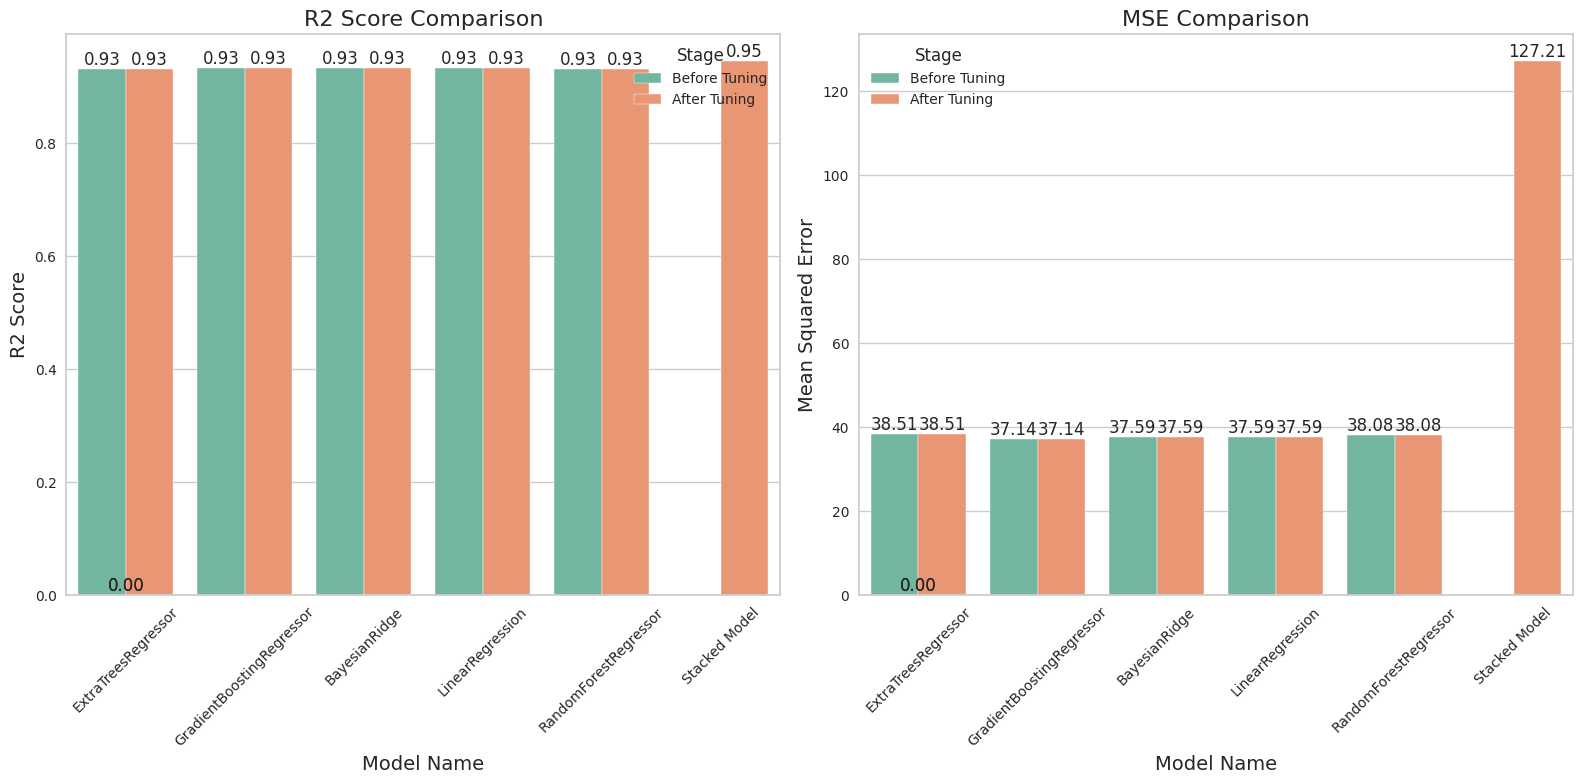


Model Evaluation Results Before Tuning:
Model Name                     R2 Score        MSE            
------------------------------------------------------------
ExtraTreesRegressor            0.9309          38.5060        
GradientBoostingRegressor      0.9333          37.1374        
BayesianRidge                  0.9325          37.5876        
LinearRegression               0.9325          37.5920        
RandomForestRegressor          0.9317          38.0793        

Model Evaluation Results After Tuning:
Model Name                     R2 Score        MSE            
------------------------------------------------------------
ExtraTreesRegressor            0.9309          38.5060        
GradientBoostingRegressor      0.9333          37.1374        
BayesianRidge                  0.9325          37.5876        
LinearRegression               0.9325          37.5920        
RandomForestRegressor          0.9317          38.0793        
Stacked Model                  0.9451    

In [ ]:
predictor.display_results()

- 단순 모델 돌린 것의 기본 평균내는 앙상블 진행

In [ ]:
# train_y와 test_y를 1차원 배열로 변환
train_y = train_y.ravel()
test_y = test_y.ravel()

# train_y = train_y.values.ravel()
# test_y = test_y.values.ravel()

model_num = 4

# 각 모델 학습
# knn_model = KNeighborsRegressor(n_neighbors=5).fit(train_x, train_y)
linear_model = LinearRegression().fit(train_x, train_y)
ridge_model = Ridge(alpha=1.0, random_state=42).fit(train_x, train_y)
rf_model = RFR(n_estimators=100, random_state=42).fit(train_x, train_y)
gbm_model = GBR(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42).fit(train_x, train_y)
cat_model= CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=False, random_seed=42).fit(train_x, train_y)

# 각 모델의 예측
# predictions_knn = knn_model.predict(test_x)
predictions_linear = linear_model.predict(test_x)
predictions_ridge = ridge_model.predict(test_x)
predictions_rf = rf_model.predict(test_x)
predictions_gbm = gbm_model.predict(test_x)
predictions_cat = cat_model.predict(test_x)


# 앙상블: 각 모델의 예측 평균
ensemble_predictions = (predictions_cat + predictions_linear + predictions_ridge + predictions_rf ) / model_num

# 앙상블 모델 성능 평가
mse_value_ensemble = mse(test_y, ensemble_predictions)
r2_value_ensemble = r2_score(test_y, ensemble_predictions)

print(f'Ensemble Model MSE: {mse_value_ensemble}')
print(f'Ensemble Model R2 Score: {r2_value_ensemble}')

# 각 모델 저장
# joblib.dump(knn_model, 'knn_model.pkl')
# joblib.dump(linear_model, 'linear_model.pkl')
# joblib.dump(ridge_model, 'ridge_model.pkl')
# joblib.dump(rf_model, 'rf_model.pkl')
# joblib.dump(gbm_model, 'gbm_model.pkl')

Ensemble Model MSE: 36.863212508869935
Ensemble Model R2 Score: 0.9338332593420509


- Stacking Ensemble

In [ ]:
# train_y와 test_y를 1차원 배열로 변환
train_y = train_y.ravel()
test_y = test_y.ravel()

# 베이스 모델 정의
base_models = [
    ('linear', LinearRegression()),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('rf', RFR(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=False, random_seed=42))
    # ('gbm', GBR(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]

# 메타 모델 정의
meta_model = LinearRegression()

# 스태킹 앙상블 모델 정의
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# 스태킹 모델 학습
stacking_model.fit(train_x, train_y)

# 스태킹 모델 예측
ensemble_predictions = stacking_model.predict(test_x)

# 스태킹 모델 성능 평가
mse_value_ensemble = mse(test_y, ensemble_predictions)
r2_value_ensemble = r2_score(test_y, ensemble_predictions)

print(f'Stacking Ensemble Model MSE: {mse_value_ensemble}')
print(f'Stacking Ensemble Model R2 Score: {r2_value_ensemble}')

# 스태킹 모델 저장
# joblib.dump(stacking_model, 'stacking_model.pkl')

Stacking Ensemble Model MSE: 37.84392715380813
Stacking Ensemble Model R2 Score: 0.932072949071874


# [Step 7] 시계열 모델 ARIMA, SARIMA. RNN/LSTM 모델 고려 할수 ~

* 시간이 된다면 위의 언급된 모델을 만들고 성능평가해 보세요.

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 데이터 로드
train_y = pd.read_csv('train_y.csv')
test_y = pd.read_csv('test_y.csv')

# ARIMA 모델 학습 - (p, d, q) 파라미터 설정
p, d, q = 5, 1, 0  # 초기 값으로 설정 (필요시 조정)
model = ARIMA(train_y, order=(p, d, q))
arima_model = model.fit()

# 예측
forecast = arima_model.forecast(steps=len(test_y))
mse_value = mean_squared_error(test_y, forecast)
r2_value = r2_score(test_y, forecast)

# 결과 출력
print("ARIMA Model Forecast:")
print(forecast)
print(f"\nARIMA Model Test MSE: {mse_value:.4f}")
print(f"ARIMA Model Test R2 Score: {r2_value:.4f}")

ARIMA Model Forecast:
8432     26.753549
8433     25.694287
8434     26.148005
8435     26.063978
8436     25.989155
           ...    
10476    26.064404
10477    26.064404
10478    26.064404
10479    26.064404
10480    26.064404
Name: predicted_mean, Length: 2049, dtype: float64

ARIMA Model Test MSE: 767.8215
ARIMA Model Test R2 Score: -0.3782


SARIMA Model Forecast:
8432     26.560230
8433     26.501251
8434     26.641489
8435     26.147557
8436     25.658549
           ...    
10476    29.666046
10477    29.492460
10478    29.883751
10479    30.070121
10480    30.013230
Name: predicted_mean, Length: 2049, dtype: float64

SARIMA Model Test MSE: 722.7922
SARIMA Model Test R2 Score: -0.2974


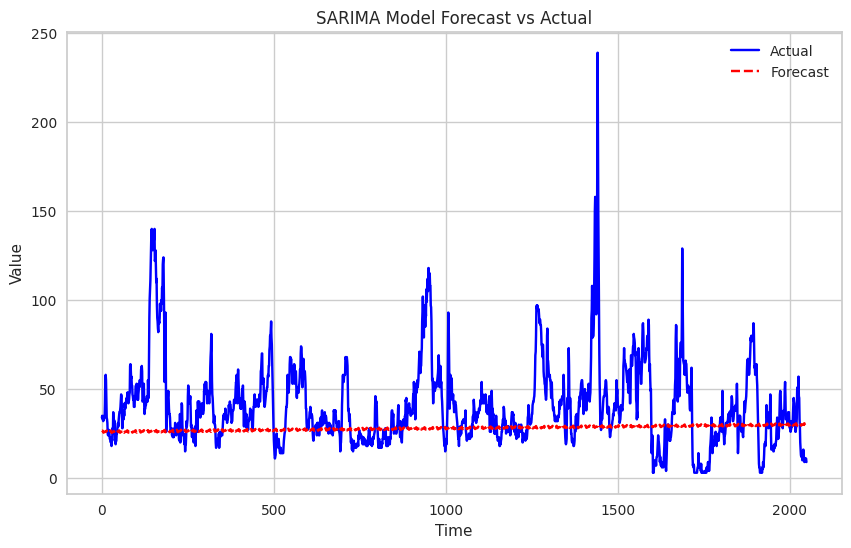

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 데이터 로드
train_y = pd.read_csv('train_y.csv')
test_y = pd.read_csv('test_y.csv')

# SARIMA 모델 설정 - (p, d, q) x (P, D, Q, s) 파라미터 설정
# p, d, q = ARIMA 파라미터
# P, D, Q, s = 계절성 ARIMA 파라미터 (s는 계절 주기)
p, d, q = 1, 1, 1  # 일반 차수
P, D, Q, s = 1, 1, 1, 12  # 계절성 차수 (12는 월간 주기 예시)

# SARIMA 모델 학습
model = SARIMAX(train_y, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model = model.fit(disp=False)

# 예측
forecast = sarima_model.forecast(steps=len(test_y))
mse_value = mean_squared_error(test_y, forecast)
r2_value = r2_score(test_y, forecast)

# 결과 출력
print("SARIMA Model Forecast:")
print(forecast)
print(f"\nSARIMA Model Test MSE: {mse_value:.4f}")
print(f"SARIMA Model Test R2 Score: {r2_value:.4f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(test_y.index, test_y, label='Actual', color='blue')
plt.plot(test_y.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SARIMA Model Forecast vs Actual')
plt.legend()
plt.show()

- LSTM 모델

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 데이터 로드
train_x = pd.read_csv('train_x.csv').values
train_y = pd.read_csv('train_y.csv').values
test_x = pd.read_csv('test_x.csv').values
test_y = pd.read_csv('test_y.csv').values

# train 데이터를 train/validation으로 분할
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False, random_state=42)

# PyTorch 데이터셋 클래스 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# 하이퍼파라미터 설정
input_size = 26      # 특성 수
hidden_size = 100    # 은닉 상태 크기 (변경됨)
num_layers = 3       # LSTM 레이어 수 (변경됨)
output_size = 1      # 출력 크기 (예측 값)
learning_rate = 0.001
num_epochs = 300
batch_size = 64

# 데이터셋 및 데이터로더 생성
train_dataset = TimeSeriesDataset(train_x, train_y)
val_dataset = TimeSeriesDataset(val_x, val_y)
test_dataset = TimeSeriesDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화 및 학습 설정
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)  # AdamW로 변경

# 모델 학습
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(-1, 1, input_size)
        y_batch = y_batch.view(-1, 1)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.view(-1, 1, input_size)
            y_batch = y_batch.view(-1, 1)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

print("모델 학습 완료")

# 테스트 데이터셋으로 평가
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.view(-1, 1, input_size)
        predictions = model(x_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f'Test MSE: {mse:.4f}')
print(f'Test R2 Score: {r2:.4f}')

- MLP 모델

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import random

# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # 원하는 시드 값으로 설정

# 데이터 로드
train_x = pd.read_csv('train_x.csv').values
train_y = pd.read_csv('train_y.csv').values
test_x = pd.read_csv('test_x.csv').values
test_y = pd.read_csv('test_y.csv').values

# train 데이터를 train/validation으로 분할
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False, random_state=42)

# PyTorch 데이터셋 클래스 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# MLP 모델 정의 (Dropout 추가)
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.3):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout 추가
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)          # 첫 번째 은닉층 이후 Dropout 적용
        x = self.relu(self.fc2(x))
        x = self.dropout(x)          # 두 번째 은닉층 이후 Dropout 적용
        out = self.fc3(x)
        return out

# 하이퍼파라미터 설정
input_size = train_x.shape[1]  # 특성 수
hidden_size = 64               # 은닉층 크기
output_size = 1                # 출력 크기
learning_rate = 0.001
num_epochs = 100
batch_size = 64
dropout_prob = 0.3             # Dropout 확률

# 데이터셋 및 데이터로더 생성
train_dataset = TimeSeriesDataset(train_x, train_y)
val_dataset = TimeSeriesDataset(val_x, val_y)
test_dataset = TimeSeriesDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화 및 학습 설정
model = MLPModel(input_size, hidden_size, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# ReduceLROnPlateau 스케줄러 설정
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early Stopping 설정
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 10

# 모델 학습
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for x_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1)  # 출력 차원 맞춤

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_batch = y_batch.view(-1, 1)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    # Learning rate 스케줄러에 validation loss 전달
    scheduler.step(val_loss)

    # Early Stopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_mlp_model.pth')

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

print("모델 학습 완료")

# 최종 모델에 가장 좋은 가중치를 로드
model.load_state_dict(torch.load('best_mlp_model.pth'))

# 테스트 데이터셋으로 평가
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f'Test MSE: {mse:.4f}')
print(f'Test R2 Score: {r2:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/100], Train Loss: 363.9697, Validation Loss: 20.6216
Epoch [20/100], Train Loss: 457.3014, Validation Loss: 17.7903
Epoch [30/100], Train Loss: 294.5546, Validation Loss: 12.3203
Epoch [40/100], Train Loss: 282.0114, Validation Loss: 12.8538
Epoch [50/100], Train Loss: 285.7821, Validation Loss: 11.6593
Epoch [60/100], Train Loss: 306.7981, Validation Loss: 10.9688
Epoch [70/100], Train Loss: 264.3549, Validation Loss: 11.0076
Epoch [80/100], Train Loss: 240.3587, Validation Loss: 10.9914
Epoch [90/100], Train Loss: 295.9417, Validation Loss: 10.9911
Epoch [100/100], Train Loss: 244.0729, Validation Loss: 10.9909
모델 학습 완료
Test MSE: 39.5026
Test R2 Score: 0.9291


<ipython-input-24-4e2f058516da>:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mlp_model.pth'))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 데이터 로드
train_x = pd.read_csv('train_x.csv').values
train_y = pd.read_csv('train_y.csv').values
test_x = pd.read_csv('test_x.csv').values
test_y = pd.read_csv('test_y.csv').values

# train 데이터를 train/validation으로 분할
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=42)

# PyTorch 데이터셋 클래스 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# MLP 모델 정의 (Dropout 추가)
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.3):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout 추가
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)          # 첫 번째 은닉층 이후 Dropout 적용
        x = self.relu(self.fc2(x))
        x = self.dropout(x)          # 두 번째 은닉층 이후 Dropout 적용
        out = self.fc3(x)
        return out

# 하이퍼파라미터 설정
input_size = train_x.shape[1]  # 특성 수
hidden_size = 64               # 은닉층 크기
output_size = 1                # 출력 크기
learning_rate = 0.001
num_epochs = 400
batch_size = 64
dropout_prob = 0.3             # Dropout 확률

# 데이터셋 및 데이터로더 생성
train_dataset = TimeSeriesDataset(train_x, train_y)
val_dataset = TimeSeriesDataset(val_x, val_y)
test_dataset = TimeSeriesDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화 및 학습 설정
model = MLPModel(input_size, hidden_size, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Early Stopping 설정
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 10

# 모델 학습
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for x_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1)  # 출력 차원 맞춤

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_batch = y_batch.view(-1, 1)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    # Early Stopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_mlp_model.pth')
    # else:
    #     early_stop_counter += 1
    #     if early_stop_counter >= early_stop_patience:
    #         print("Early stopping!")
    #         break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

print("모델 학습 완료")

# 최종 모델에 가장 좋은 가중치를 로드
model.load_state_dict(torch.load('best_mlp_model.pth'))

# 테스트 데이터셋으로 평가
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f'Test MSE: {mse:.4f}')
print(f'Test R2 Score: {r2:.4f}')

Epoch [10/400], Train Loss: 293.7886, Validation Loss: 158.2170
Epoch [20/400], Train Loss: 281.6344, Validation Loss: 166.7143
Epoch [30/400], Train Loss: 241.1559, Validation Loss: 126.5352
Epoch [40/400], Train Loss: 242.4418, Validation Loss: 140.0317
Epoch [50/400], Train Loss: 245.3891, Validation Loss: 150.8807
Epoch [60/400], Train Loss: 243.7129, Validation Loss: 136.4112
Epoch [70/400], Train Loss: 254.3749, Validation Loss: 170.5050
Epoch [80/400], Train Loss: 212.0372, Validation Loss: 120.6600
Epoch [90/400], Train Loss: 197.3609, Validation Loss: 196.5222
Epoch [100/400], Train Loss: 192.2599, Validation Loss: 152.8703
Epoch [110/400], Train Loss: 180.9227, Validation Loss: 126.0675
Epoch [120/400], Train Loss: 206.3903, Validation Loss: 133.4700
Epoch [130/400], Train Loss: 269.2619, Validation Loss: 245.9440
Epoch [140/400], Train Loss: 236.3237, Validation Loss: 120.1646
Epoch [150/400], Train Loss: 214.5122, Validation Loss: 165.8444
Epoch [160/400], Train Loss: 234.7

Epoch [10/300], Train MSE: 452.6389, Validation MSE: 45.2802, Train R2: 0.8325, Validation R2: 0.5765, Learning Rate: 0.001000
Epoch [20/300], Train MSE: 303.9752, Validation MSE: 25.9927, Train R2: 0.8875, Validation R2: 0.7569, Learning Rate: 0.001000
Epoch [30/300], Train MSE: 282.3473, Validation MSE: 18.3808, Train R2: 0.8955, Validation R2: 0.8281, Learning Rate: 0.001000
Epoch [40/300], Train MSE: 267.3461, Validation MSE: 23.7471, Train R2: 0.9011, Validation R2: 0.7779, Learning Rate: 0.001000
Epoch [50/300], Train MSE: 306.0149, Validation MSE: 19.1437, Train R2: 0.8868, Validation R2: 0.8209, Learning Rate: 0.000500
Epoch [60/300], Train MSE: 223.8240, Validation MSE: 18.9416, Train R2: 0.9172, Validation R2: 0.8228, Learning Rate: 0.000500
Epoch [70/300], Train MSE: 244.9995, Validation MSE: 14.4089, Train R2: 0.9094, Validation R2: 0.8652, Learning Rate: 0.000500
Epoch [80/300], Train MSE: 261.2379, Validation MSE: 12.4678, Train R2: 0.9033, Validation R2: 0.8834, Learning

<ipython-input-36-0fbaecba01bb>:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mlp_model_scheduler.pth'))


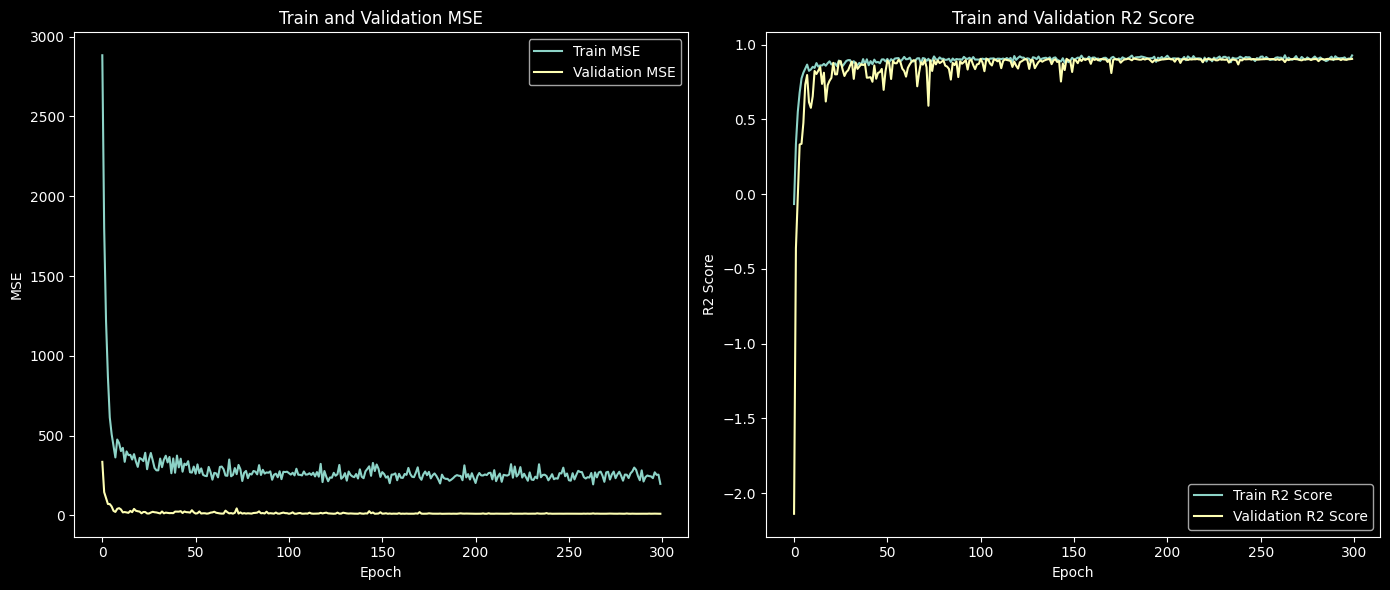

In [36]:
import sys
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
train_x = pd.read_csv('train_x.csv').values
train_y = pd.read_csv('train_y.csv').values
test_x = pd.read_csv('test_x.csv').values
test_y = pd.read_csv('test_y.csv').values

# train 데이터를 train/validation으로 분할
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False, random_state=42)

class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.3):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

# 하이퍼파라미터 설정
input_size = train_x.shape[1]  # 특성 수
hidden_size = 64               # 은닉층 크기
output_size = 1                # 출력 크기
learning_rate = 0.001
num_epochs = 300
batch_size = 64
dropout_prob = 0.3             # Dropout 확률

# 데이터셋 및 데이터로더 생성
train_dataset = TimeSeriesDataset(train_x, train_y)
val_dataset = TimeSeriesDataset(val_x, val_y)
test_dataset = TimeSeriesDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화 및 학습 설정
model = MLPModel(input_size, hidden_size, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# 스케줄러 설정
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Early Stopping 설정
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 10

# 성능 기록을 위한 리스트
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

# 모델 학습
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    y_train_true = []
    y_train_pred = []
    for x_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1)  # 출력 차원 맞춤

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # 예측 결과 저장 (R2 계산용)
        y_train_true.extend(y_batch.numpy())
        y_train_pred.extend(output.detach().numpy())

    # Train loss & R2 score 계산
    train_mse = mean_squared_error(y_train_true, y_train_pred)
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_losses.append(train_mse)
    train_r2_scores.append(train_r2)

    # Validation loss 계산
    model.eval()
    val_loss = 0.0
    y_val_true = []
    y_val_pred = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_batch = y_batch.view(-1, 1)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

            # 예측 결과 저장 (R2 계산용)
            y_val_true.extend(y_batch.numpy())
            y_val_pred.extend(output.numpy())

    # Validation MSE & R2 score
    val_mse = mean_squared_error(y_val_true, y_val_pred)
    val_r2 = r2_score(y_val_true, y_val_pred)
    val_losses.append(val_mse)
    val_r2_scores.append(val_r2)

    # Early Stopping 체크
    if val_mse < best_val_loss:
        best_val_loss = val_mse
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_mlp_model_scheduler.pth')


    # 학습률 스케줄러 업데이트
    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}, Train R2: {train_r2:.4f}, Validation R2: {val_r2:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

print("모델 학습 완료")

# 최종 모델에 가장 좋은 가중치를 로드
model.load_state_dict(torch.load('best_mlp_model_scheduler.pth'))

# 그래프 시각화
plt.figure(figsize=(14, 6))

# MSE 그래프
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train MSE')
plt.plot(range(len(val_losses)), val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Train and Validation MSE')

# R2 Score 그래프
plt.subplot(1, 2, 2)
plt.plot(range(len(train_r2_scores)), train_r2_scores, label='Train R2 Score')
plt.plot(range(len(val_r2_scores)), val_r2_scores, label='Validation R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.title('Train and Validation R2 Score')

plt.tight_layout()
plt.show()

<ipython-input-20-f6ee2056be1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mlp_model_scheduler.pth'))


Test MSE: 38.5154
Test R2 Score: 0.9309


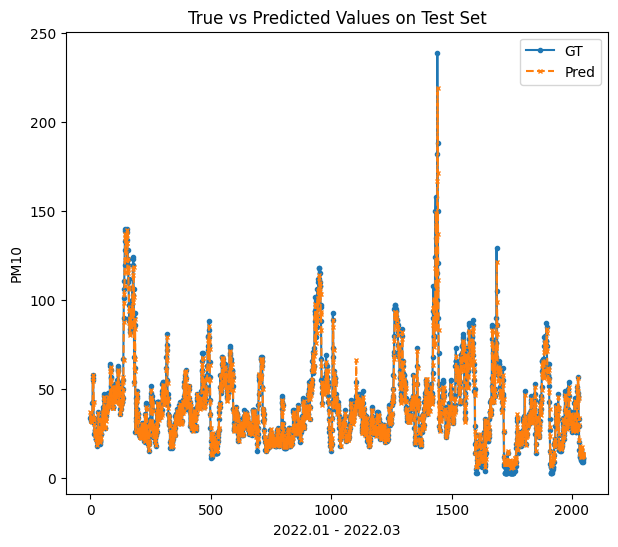

In [20]:
# 최종 모델에 가장 좋은 가중치를 로드
model.load_state_dict(torch.load('best_mlp_model_scheduler.pth'))

# 테스트 데이터셋으로 평가
model.eval()
y_test_true = []
y_test_pred = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        y_test_true.extend(y_batch.numpy())
        y_test_pred.extend(predictions.numpy())

# 성능 평가
test_mse = mean_squared_error(y_test_true, y_test_pred)
test_r2 = r2_score(y_test_true, y_test_pred)
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R2 Score: {test_r2:.4f}')

# 테스트 성능 시각화
plt.figure(figsize=(7, 6))

# 실제 값과 예측 값 비교 그래프
plt.plot(y_test_true, label="GT", marker='o', linestyle='-', markersize=3)
plt.plot(y_test_pred, label="Pred", marker='x', linestyle='--', markersize=3)
plt.xlabel("2022.01 - 2022.03")
plt.ylabel("PM10")
plt.legend()
plt.title("True vs Predicted Values on Test Set")
plt.show()

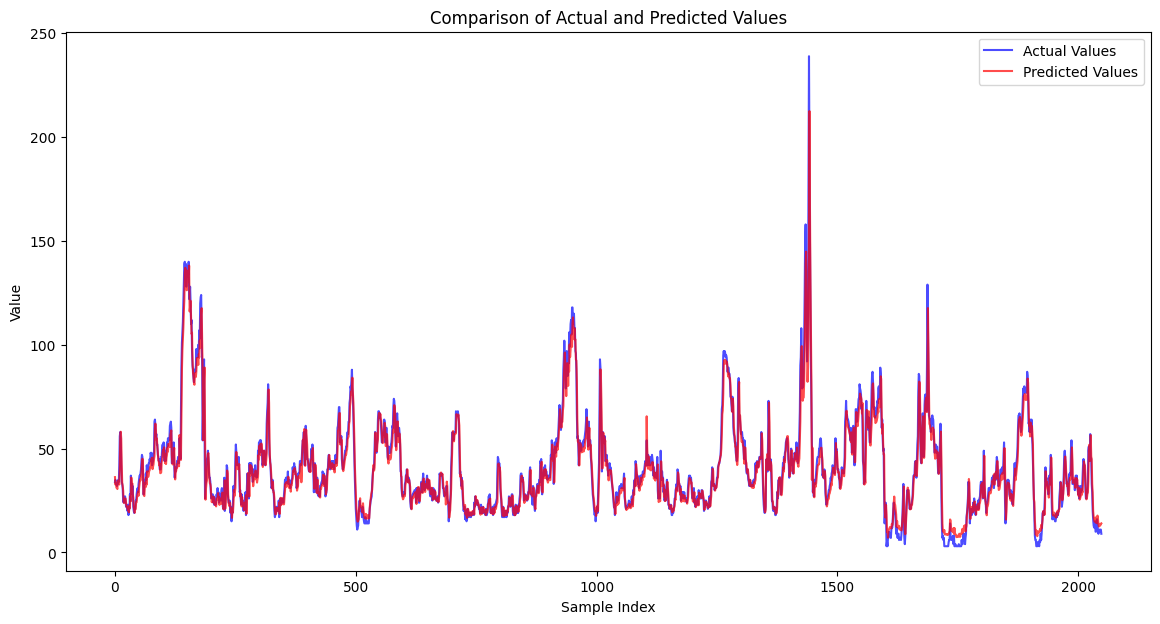

In [ ]:
import matplotlib.pyplot as plt

# 시각화: 예측 데이터와 실제 값 비교
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Actual Values', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Values', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

### 딥러닝으로 해당 데이터셋 돌린 결과 알 수 있는 정보들
1. 튜닝도 하지 않았던 기본 ML 모델들 성능이 R2 기준 0.93을 넘었지만, 시계열 데이터의 모델을 돌렸을 때(ARIMA, SARIMA, LSTM 등) R2스코어가 정상적이지 않게 음수가 나오는 것을 확인 가능
2. 해당 데이터는 시계열 데이터 셋이지만, 시계열으로 학습했을 때 성능이 저하되는 것을 확인 가능하다.
    -> 왜그렇게 생각 하였냐면, LSTM train dataset loader에서 인자로 suffle = False로 설정해야 시간 순, 시계열 데이터의 의미를 가지게 학습 시킬 수 있는 건데 그렇게 설정시 R2스코어가 음수가 나오고, shuffle = True로 인자를 줄 시에는 R2 스코어가 0.929까지 나온 것을 보아 해당 데이터 셋은 시계열로 학습을 시키면 안된다고 생각하였다
3. 추가 위 정보를 바탕으로 굳이 시계열 데이터 처럼 RNN, LSTM 등을 학습 시킬 필요가 없다는 것을 이유로 간단한 구조의 MLP를 만들어 돌렸지만 R2 스코어 0.9315로 꽤 높은 성능을 보임
4. 하지만 기본 ML LinearRegression으로도 R2스코어가 0.932까지 나오는데 딥러닝으로 그 스코어를 못 넘는다는 것은 역시 이해가 되지 않음, 모델 구조를 더 복잡하게 하거나, 다른 Optimizer를 사용하고, scheduler를 사용해봤지만 복잡하지 않을 수록 성능이 올라가는 것으로 보임.